In [1]:
import timm
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

# Images
## Download Dog Images

In [2]:
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# Function to download dog images
def download_dog_images(num_images=10):
    url = "https://dog.ceo/api/breeds/image/random"
    images = []

    for i in tqdm(range(num_images)):
        response = requests.get(url)
        if response.status_code == 200:
            image_url = response.json()['message']
            img_response = requests.get(image_url)
            img = Image.open(BytesIO(img_response.content))
            images.append(img)
            # Display the image (optional)
            img.show()

    return images

# Download 10 random dog images
downloaded_images = download_dog_images()

100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


In [3]:
from PIL import Image
import torchvision.transforms as transforms
import torch as t


# Preprocess the image
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to grayscale
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
])
input_tensor = torch.stack([preprocess(image) for image in downloaded_images])
input_tensor.shape

torch.Size([10, 3, 224, 224])

## Deform Images

In [4]:
def sin_distortion(x_length: int,
                   y_length: int,
                   A_nm: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """
    Sin distortion for creating deformation maps.

    Args:
    - x_length (int): Length of x-axis of image.
    - y_length (int): Length of y-axis of image.
    - A_nm (torch.Tensor): Square matrix of coefficients. Sets size of cut off.

    Returns:
    (torch.Tensor, torch.Tensor): Deformation maps for x and y coordinates.
    """
    if A_nm.shape[0] != A_nm.shape[1]:
        raise ValueError('A_nm must be square matrix.')

    A_nm = A_nm.float()

    # Create Coordinates
    x = torch.linspace(-1, 1, x_length, dtype=torch.float32)
    y = torch.linspace(-1, 1, y_length, dtype=torch.float32)
    X, Y = torch.meshgrid(x, y, indexing='ij')

    # Create Diffeo
    x_pert = torch.linspace(0, 1, x_length, dtype=torch.float32)
    y_pert = torch.linspace(0, 1, y_length, dtype=torch.float32)

    n = torch.arange(1, A_nm.shape[0] + 1, dtype=torch.float32)
    x_basis = torch.sin(torch.pi * torch.outer(n, x_pert)).T
    y_basis = torch.sin(torch.pi * torch.outer(n, y_pert))

    perturbation = torch.matmul(x_basis, torch.matmul(A_nm, y_basis))

    x_map = X + perturbation
    y_map = Y + perturbation

    return x_map, y_map

def apply_transformation(image_tensor,
                         A_nm: torch.Tensor,
                         interpolation_type='bilinear'):
    """
    Wrapper of `sin_distortion`. Gets torch.tensor and returns the distorted
    torch.tensor according to A_nm.

    Args:
        image_tensor (torch.Tensor): Inputted image.
        A_nm (torch.Tensor): Characterizes diffeo according to `sin_distortion`.
        interpolation_type (str): Interpolation method ('bilinear' or 'nearest').

    Returns:
        image_tensor_deformed (torch.Tensor): Diffeo applied to `image_tensor`.
    """
    # Create deformation map
    x_length, y_length = image_tensor.shape[1:3]
    x_map, y_map  = sin_distortion(x_length, y_length, A_nm)

    return apply_flowgrid(image_tensor, x_map, y_map, interpolation_type=interpolation_type)


def apply_flowgrid(image_tensor, x_map, y_map, interpolation_type='bilinear'):
    # Stack and unsqueeze to form grid
    grid = torch.stack((y_map, x_map), dim=-1).unsqueeze(0).to(image_tensor.device)

    # Apply grid sample
    image_tensor_deformed = torch.nn.functional.grid_sample(image_tensor.unsqueeze(0),
                                                            grid,
                                                            mode=interpolation_type,
                                                            align_corners=True)

    return image_tensor_deformed.squeeze(0)

Diffeo Strength:  0.14177446067333221
torch.Size([2, 10, 3, 224, 224])


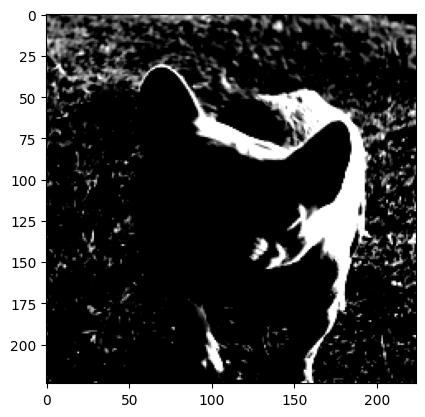

In [5]:
A_nm = torch.tensor([[0.0, 0.14],
                     [-0.02, 0.01]])
print('Diffeo Strength: ', float(A_nm.norm()))

input_tensor_diffeoed = [apply_transformation(tensor, A_nm) for tensor in input_tensor]
input_tensor_diffeoed = torch.stack(input_tensor_diffeoed)

input_batch = torch.stack([input_tensor, input_tensor_diffeoed], dim=0)

shape_categories = input_batch.shape[0]
shape_images = input_batch.shape[1]
shape_channel = input_batch.shape[2]
shape_pixels = input_batch.shape[3]

print(input_batch.shape)
plt.imshow(input_tensor_diffeoed[2].permute(1, 2, 0))

## Learn Inverse Defformation

In [6]:
class add_bias_to_grid(torch.nn.Module):
  def __init__(self, grid):
    # grid should have the shape of a grid_sample grid, i.e. (Channel, X, Y, 2)
    super().__init__()
    self.grid = grid
    self.bias = torch.nn.Parameter(torch.zeros_like(grid[:,1:-1,1:-1,:]))
  def forward(self):
    return self.grid + torch.nn.functional.pad(self.bias, (0,0,1,1,1,1), "constant", 0)

def find_inv_grid(flow_grid, mode ='bilinear', learning_rate = 0.001, epochs = 10000, early_stopping = True):
  batch, x_length, y_length, _ = flow_grid.shape
  x = torch.linspace(-1, 1, steps = x_length)
  y = torch.linspace(-1, 1, steps = y_length)
  X, Y = torch.meshgrid(x, y, indexing='ij')
  reference = torch.stack((X, Y, X * Y), dim=0).unsqueeze(0).repeat(batch, 1, 1, 1)
  #, torch.cos(2*math.pi*X) * torch.cos(2*math.pi*Y)
  id_grid = torch.stack((Y, X), dim=-1).unsqueeze(0).repeat(batch, 1, 1, 1)
  #2 * id_grid - flow_grid
  find_inv_model = add_bias_to_grid(id_grid)
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.SGD(find_inv_model.parameters(), lr = learning_rate)

  num_epochs = epochs
  loss_hist = []
  min_loss = 1e30
  early_stopping_count = 0
  for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    output = find_inv_model()
    distort = torch.nn.functional.grid_sample(reference, flow_grid, mode = mode)
    #inv_distort = torch.nn.functional.grid_sample(reference, output, mode = mode)
    restored_left  = torch.nn.functional.grid_sample(distort, output, mode = mode)
    #restored_right = torch.nn.functional.grid_sample(inv_distort, flow_grid, mode = mode)
    left_loss = loss_fn(reference, restored_left)
    #right_loss = loss_fn(reference, restored_right)
    loss = left_loss #+ right_loss #+ (torch.exp(torch.abs(left_loss-right_loss)**2) - 1)
    #loss =  left_loss + right_loss
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 20 == 0:
          loss_hist.append(loss.item())
          if loss_hist[-1]/min_loss >= 1:
            early_stopping_count += 1
            print(f'Early stopping count: {early_stopping_count}')
          if loss_hist[-1] < min_loss:
            min_loss = loss_hist[-1]
            early_stopping_count = 0
    if early_stopping and early_stopping_count >=7:
      print('Finished!')
      break

  with torch.no_grad():
    flow_grid_inverse_neural = find_inv_model().detach().clone()

  return flow_grid_inverse_neural, loss_hist

In [7]:
x_length, y_length = 64, 64
x_map, y_map = sin_distortion(x_length, y_length, A_nm)

flow_grid = torch.stack((y_map, x_map), dim=-1)
flow_grid = flow_grid.unsqueeze(0)

flow_gridInverse, _ = find_inv_grid(flow_grid, learning_rate=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4902: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
  2%|▏         | 159/10000 [00:00<00:11, 823.87it/s]

Early stopping count: 1
Early stopping count: 2
Early stopping count: 3
Early stopping count: 4
Early stopping count: 5
Early stopping count: 6
Early stopping count: 7
Finished!


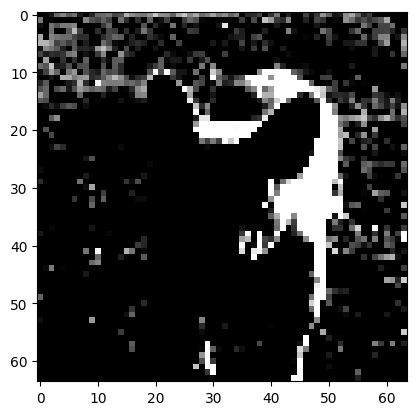

In [8]:
image_tensor_undeformed = torch.nn.functional.grid_sample(input_tensor_diffeoed[2].unsqueeze(0),
                                                          flow_gridInverse,
                                                          align_corners=True)
plt.imshow(
    image_tensor_undeformed.squeeze(0).permute(1, 2, 0)
    )

# Image Classification Model

In [9]:
# Load a pre-trained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [10]:
def get_activation(model, input, layer_index: list):

  activation = {}
  def getActivation(name):
      # the hook signature
      def hook(model, input, output):
          activation[name] = output.detach()
      return hook

  handles = []
  def retrieve_layer_activation(model, input, layer_index):
    if len(input) == 3: input = input[None, :, :, :]

    layers = list(model.children())
    layers_flat = flatten(layers)

    for index in layer_index:
      handles.append(layers_flat[index - 1].register_forward_hook(getActivation(str(index))))

    with t.no_grad(): model(input)
    for handle in handles: handle.remove()

    return

  def flatten(array):
      result = []
      for element in array:
          if hasattr(element, "__iter__"):
              result.extend(flatten(element))
          else:
              result.append(element)
      return result

  retrieve_layer_activation(model, input, layer_index)
  return activation

In [11]:
input_batch.shape

torch.Size([2, 10, 3, 224, 224])

In [12]:
layer_id = 13

# Move the input and model to the appropriate device (e.g., GPU if available)
device = t.device("cuda" if t.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)
model.to(device)

# Get the activation of a specific layer
input_batch = input_batch.reshape(shape_categories * shape_images, shape_channel, shape_pixels, shape_pixels)

In [13]:
activations = get_activation(model, input_batch, [layer_id])[f'{layer_id}']
activations = activations.reshape(shape_categories, shape_images, *activations.shape[1:])

original_activation = activations[0]
diffeo_activation = activations[1]

activations.shape, original_activation.shape, diffeo_activation.shape

(torch.Size([2, 10, 197, 768]),
 torch.Size([10, 197, 768]),
 torch.Size([10, 197, 768]))

In [14]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 86567656


# Regression

In [15]:
class Autoencoder(nn.Module):
  def __init__(self, flow_grid, dtype=torch.float32):
    super(Autoencoder, self).__init__()

    # Parameters for model
    self.flow_grid = flow_grid
    input_size = 197 * 768
    self.image_length = 64
    self.compression_size = self.image_length**2

    # Model
    self.encoder = nn.Sequential(
        nn.Linear(input_size, self.compression_size),
    )
    self.decoder = nn.Sequential(
        nn.Linear(self.compression_size, input_size),
    )
    self.to(dtype)

  def forward(self, x):
    batch_size = x.size(0)

    # Encoder
    x = self.encoder(x)

    # g^{-1}_{naive}
    x = x.reshape(batch_size, 1, self.image_length, self.image_length) # b&w image
    # x = x.reshape(x.shape[0], 1, self.image_length, self.image_length) # color image
    flow_grid_expanded = self.flow_grid.expand(batch_size, -1, -1, -1)  # Expand to match batch size
    x = torch.nn.functional.grid_sample(x,
                                        flow_grid_expanded,
                                        align_corners=True)
    x = x.reshape(batch_size, self.compression_size)

    # Decoder
    x = self.decoder(x)
    return x

### Run Experiment

In [16]:
import torch.optim as optim

In [23]:
dtype = torch.float32

In [24]:
# Model
autoencoder = Autoencoder(flow_grid=flow_gridInverse, dtype=dtype)
autoencoder.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=151296, out_features=4096, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4096, out_features=151296, bias=True)
  )
)

In [25]:
trainable_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

Trainable parameters: 1239572224


In [26]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.MSELoss()  # Example loss function

In [ ]:
X = diffeo_activation.view(diffeo_activation.size(0), -1).to(dtype)
y = original_activation.view(original_activation.size(0), -1).to(dtype)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    output = autoencoder(X)

    # Compute loss
    loss = criterion(output, y)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Print loss
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")